In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# Import dependencies
import numpy as np
from cellpose_omni import models, core

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
use_GPU = core.use_gpu()
print('>>> GPU activated? {}'.format(use_GPU))

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')
%matplotlib inline
from glob import glob

2024-04-27 19:42:08,749 [INFO] ** TORCH GPU version installed and working. **
>>> GPU activated? True


/home/gh464/miniconda3/envs/omnipose_2024/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pathlib import Path
import os
from cellpose_omni import io
import omnipose
files = glob("single_projected_cells_for_DL_green_masks/*.png")
files = [file for file in files if "masks.png" not in file]

In [38]:
model_name = "single_projected_cells_for_DL_green_masks/models/cellpose_residual_on_style_on_concatenation_off_omni_abstract_nclasses_2_nchan_1_dim_2_single_projected_cells_for_DL_green_masks_2024_04_27_18_44_46.600558_epoch_3999"
model_name = "single_projected_cells_for_DL_darkred_masks//models/cellpose_residual_on_style_on_concatenation_off_omni_abstract_nclasses_2_nchan_1_dim_2_single_projected_cells_for_DL_darkred_masks_2024_04_27_18_46_00.717534_epoch_3400"

model = models.CellposeModel(gpu=True, pretrained_model=model_name, nchan=1, nclasses=2,dim=2)
epoch = model_name.split("_")[-1]

chans = None

# define parameters
mask_threshold = -1
verbose = 0 # turn on if you want to see more output
use_gpu = use_GPU #defined above
transparency = True # transparency in flow output
rescale=None # give this a number if you need to upscale or downscale your images
omni = True # we can turn off Omnipose mask reconstruction, not advised
flow_threshold = 0 # default is .4, but only needed if there are spurious masks to clean up; slows down output
resample = True #whether or not to run dynamics on rescaled grid or original grid

2024-04-27 19:47:40,849 [INFO] ** TORCH GPU version installed and working. **
2024-04-27 19:47:40,850 [INFO] >>>> using GPU


In [39]:
import pickle
with open('cells_dict.pickle', 'rb') as handle:
    cells = pickle.load(handle)

In [40]:
len(cells)

52

In [46]:
from cellpose_omni import io, transforms
from omnipose.utils import normalize99

true_widths = []
obs_widths = []

for cell in cells:
    
    imgs = [cell["resized_projection"]]
    
    
    for k in range(len(imgs)):
        img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
        if len(img.shape)>2:
            # imgs[k] = img[:,:,1] # could pick out a specific channel
            imgs[k] = np.mean(img,axis=-1) # or just turn into grayscale 
            
        imgs[k] = normalize99(imgs[k])
        # imgs[k] = np.pad(imgs[k],10,'edge')
    
    chans = None
    
    
    
    # define parameters
    params = {'channels':chans, # always define this with the model
              'rescale': None, # upscale or downscale your images, None = no rescaling 
              'mask_threshold': -1, # erode or dilate masks with higher or lower values 
              'flow_threshold': 0, # default is .4, but only needed if there are spurious masks to clean up; slows down output
              'transparency': True, # transparency in flow output
              'omni': True, # we can turn off Omnipose mask reconstruction, not advised 
              'cluster': True, # use DBSCAN clustering
              'resample': True, # whether or not to run dynamics on rescaled grid or original grid 
              'verbose': False, # turn on if you want to see more output 
              'tile': False, # average the outputs from flipped (augmented) images; slower, usually not needed 
              'niter': 7, # None lets Omnipose calculate # of Euler iterations (usually <20) but you can tune it for over/under segmentation 
              'augment': False, # Can optionally rotate the image and average outputs, usually not needed 
              'affinity_seg': False, # new feature, stay tuned...
             }
    
    tic = time.time() 
    masks, flows, styles = model.eval([imgs[i] for i in [0]],**params)
    
    net_time = time.time() - tic
    
    mask = masks[0]
    
    obs_width = (np.sum(mask[mask.shape[0]//2]) * 0.065)
    obs_widths.append(obs_width)
    true_width = (np.sum(cell["mask"][cell["mask"].shape[0]//2]) * 0.065)
    true_widths.append(true_width)

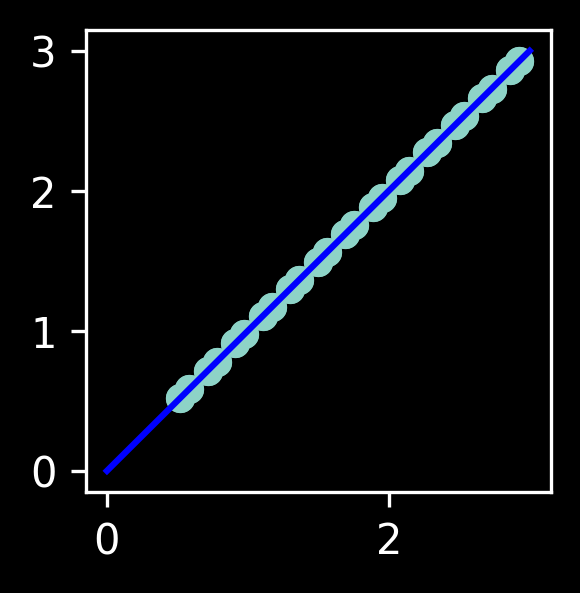

In [47]:
plt.figure(figsize=(2,2))
plt.scatter(true_widths, obs_widths)
plt.plot([0,3],[0,3], c = "blue")

In [49]:
true_widths

[0.78,
 1.9500000000000002,
 1.495,
 1.7550000000000001,
 2.9250000000000003,
 1.365,
 0.9750000000000001,
 1.885,
 0.91,
 1.17,
 0.91,
 2.73,
 2.08,
 0.7150000000000001,
 1.365,
 2.47,
 1.105,
 1.3,
 1.495,
 2.275,
 2.145,
 0.78,
 2.34,
 2.47,
 0.9750000000000001,
 2.275,
 2.8600000000000003,
 1.9500000000000002,
 1.885,
 2.665,
 1.69,
 0.52,
 0.7150000000000001,
 1.7550000000000001,
 1.3,
 1.56,
 2.8600000000000003,
 2.34,
 1.105,
 1.69,
 2.73,
 1.17,
 1.56,
 0.585,
 2.9250000000000003,
 2.665,
 0.585,
 2.535,
 0.52,
 2.145,
 2.535,
 2.08]